SpikeCounter/batch_split_embryo_array.py /n/holyscratch01/cohen_lab/bjia/20220620_ncx_atp1a1_MOs/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20220620_ncx_atp1a1_MOs/corrected/ --expt_index morpholino

In [1]:
import sys
from pathlib import Path
import os
import importlib
import warnings
SPIKECOUNTER_PATH = Path(os.getenv("SPIKECOUNTER_PATH"))
sys.path.append(SPIKECOUNTER_PATH.as_posix())

In [2]:
import numpy as np
import skimage.io as skio
import scipy.io as scio
from scipy import ndimage, signal, stats, fft
from skimage import filters, registration

import scipy.ndimage as ndimage
import pandas as pd
import pickle
import imagesize

import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
from statannotations.Annotator import Annotator

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils

biopubs_style = SPIKECOUNTER_PATH/"config"/"bio_publications.mplstyle"
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [3]:
expt_dir_name = "20220620_ncx_atp1a1_MOs"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure3/", expt_dir_name)
subfolder = "corrected"
output_datadir.mkdir(parents=True, exist_ok=True)

In [6]:
expt_info = utils.process_experiment_metadata(
    pd.read_csv(rootdir / subfolder / "analysis" / "experiment_data.csv"),
    regexp_dict={"morpholino": r"(?<=_)\w+(?=_t1)"},
)
if "level_0" in expt_info.columns:
    del expt_info["level_0"]
expt_info = expt_info.set_index("morpholino")
expt_info.to_csv(rootdir / "analysis" / "experiment_data.csv")

In [4]:
expt_info = pd.read_csv(rootdir / "analysis" / "experiment_data.csv", index_col=0)

Check results of splitting to make sure they're accurate

In [5]:
def plot_embryo_splitting(mo, embryos):
    plt.close("all")
    mo_metadata = expt_info.loc[mo]
    for emb in embryos:
        directory = Path(rootdir, subfolder, "analysis", "individual_fish_recordings", mo, f"E{emb}")
        mean_images = []
        for i in range(mo_metadata.shape[0]):
            file_name = mo_metadata["file_name"].iloc[i]
            im = skio.imread(Path(directory, f"E{emb}_{file_name}.tif"))
            mean_images.append(im.mean(axis=0))
        fig1, axes = visualize.tile_plots_conditions(mean_images, (3,3), disp_titles=False)
        fig1.suptitle(f"E{emb}")
        for i, im in enumerate(mean_images):
            axes[i].imshow(im)

In [ ]:
%matplotlib inline
plot_embryo_splitting("atp", range(1,16))

In [ ]:
%matplotlib inline
plot_embryo_splitting("slc", range(1,15))

Perform PCA on videos for each individual embryo

In [41]:
def pad_to_size(img, size):
    diffs = np.array(size) - np.array(img.shape)
    diffs[diffs < 0] = 0
    if ~np.any(diffs):
        return img
    else:
        padded_img = np.pad(img, ((0, diffs[0]), (0, diffs[1])), mode="edge")
        return padded_img


def get_global_max_size(embryo, directory, file_names):
    image_sizes = []
    for file_name in file_names:
        image_sizes.append(
            imagesize.get(os.path.join(directory, "E%d_%s.tif" % (embryo, file_name)))
        )
    image_sizes = np.array(image_sizes)
    max_image_size = image_sizes.max(axis=0)[::-1]
    return max_image_size

def extract_single_video_data(im, krt_thresh=27, min_size=50):
    hp_filt = signal.cheby1(4, 0.5, 0.1, btype="highpass", output="sos", fs=10)
    mean_img = im.mean(axis=0)
    im = signal.sosfiltfilt(hp_filt, im, axis=0)
    mask = np.zeros(im.shape[1:], dtype=bool)
    n_blocks = 4
    block_bounds = im.shape[1]//n_blocks
    mask[block_bounds:(n_blocks-1)*block_bounds] = images.get_heart_mask(im[:,block_bounds:(n_blocks-1)*block_bounds],
                    krt_thresh=krt_thresh, min_size=min_size)
    # print(mask.shape)
    return mask, mean_img

def extract_video_seq_data(video_seq, krt_threshold=27, min_size=50):
    for v in video_seq:
        yield extract_single_video_data(v, krt_thresh=krt_threshold, min_size=min_size)

In [43]:
def process_single_embryo(mo, e, mo_metadata, krt_threshold=27, min_size=50, is_control=False, save=True, plot=True):
    file_names = mo_metadata["file_name"].values
    directory = Path(rootdir, subfolder, "analysis", "individual_fish_recordings", mo, f"E{e}")
    global_max_image_size = get_global_max_size(e, directory, file_names)
    # Create a lazy generator of embryo images    
    embryo_images = (skio.imread(directory / f"E{e}_{file_name}.tif") for file_name in file_names)
    
    # Extract mean and segmented heart mask
    data = extract_video_seq_data(embryo_images, krt_threshold=krt_threshold, min_size=min_size)
    masks, mean_images = zip(*data)
    mask_areas = [np.sum(mask) for mask in masks]

    # Get the shifts to align the images over time
    padded_mean_images = [pad_to_size(im, global_max_image_size) for im in mean_images]
    valid_xcorr_masks = [im > filters.threshold_otsu(im) for im in padded_mean_images]
    def get_shifts_from_prev(i):
        # register to previous image
        shifts = registration.phase_cross_correlation(padded_mean_images[i-1], 
                    padded_mean_images[i], reference_mask=valid_xcorr_masks[i-1],
                    moving_mask=valid_xcorr_masks[i]) 
        return shifts
    all_shifts = [np.array([0,0])] + [get_shifts_from_prev(i) for i in range(1, len(padded_mean_images))]
    all_shifts = np.array(all_shifts)
    all_shifts = np.cumsum(all_shifts, axis=0)
    registered_masks = np.array([ndimage.shift(pad_to_size(mask, global_max_image_size), all_shifts[i],
                mode="nearest") for i, mask in enumerate(masks)])

    # Fill in any timepoints with missing masks
    registered_masks = images.fill_missing_timepoints(registered_masks.astype(int),
                        min_size=40, max_size=135).astype(bool)
    
    # Remove any large jumps in the masks by assuming the heart is roughly in the same place
    registered_masks = images.remove_large_jumps(registered_masks, direction="rev")

    # Extract the traces from the images using the registered masks
    def get_traces_from_seq(seq):
        for i, im in enumerate(seq):
            mask = registered_masks[i]
            deshifted_mask = ndimage.shift(mask, -all_shifts[i], mode="nearest")
            deshifted_mask = deshifted_mask[:im.shape[1], :im.shape[2]]
            yield images.extract_mask_trace(im, deshifted_mask)
    embryo_images = (skio.imread(directory / f"E{e}_{file_name}.tif") for file_name in file_names)
    embryo_traces = np.array([trace for trace in get_traces_from_seq(embryo_images)])

    if is_control:
        color = "C1"
    else:
        color = "C0"

    # Plot the results
    if plot:
        fig1, axes = visualize.tile_plots_conditions(embryo_traces, (12,2), disp_titles=False, n_rows=len(embryo_traces))
        fig2, axes2 = visualize.tile_plots_conditions(masks, (1.5,1.5), disp_titles=False)
        fig3, axes3 = visualize.tile_plots_conditions(masks, (1.5,1.5), disp_titles=False)
        axes = axes.ravel()
        axes2 = axes2.ravel()
        axes3 = axes3.ravel()

        for i in range(len(embryo_traces)):
            axes[i].plot(embryo_traces[i], color=color)
            axes[i].set_axis_off()
            axes[i].set_title("%d min" % (mo_metadata.iloc[i]["offset"]/60))

        for i in range(len(masks)):
            visualize.display_roi_overlay(mean_images[i], ndimage.shift(registered_masks[i],
                            -all_shifts[i], mode="nearest")[:mean_images[i].shape[0],:mean_images[i].shape[1]], ax=axes2[i])
            visualize.display_roi_overlay(mean_images[i], masks[i], ax=axes3[i])
            axes2[i].set_axis_off()
            axes3[i].set_axis_off()
            axes2[i].set_title("%d min" % (mo_metadata.iloc[i]["offset"]/60))
            axes3[i].set_title("%d min" % (mo_metadata.iloc[i]["offset"]/60))
        
        for fig in [fig1, fig2, fig3]:
            plt.figure(fig.number)
            plt.tight_layout()
    # If save is True, save the results
    if save:
        with open(os.path.join(directory, "heart_masks.pickle"), "wb") as f:
            pickle.dump(masks, f)
        skio.imsave(Path(directory) / "registered_masks.tif", registered_masks.astype(np.uint8))
        registered_mean_images = np.array([ndimage.shift(im, all_shifts[i],
            mode="nearest") for i, im in enumerate(padded_mean_images)])
        skio.imsave(Path(directory) / "registered_mean_images.tif", registered_mean_images.astype(np.uint16))
        if plot:
            plt.figure(fig1.number)
            plt.savefig(os.path.join(directory, "embryo_traces.svg"))
            plt.figure(fig2.number)
            plt.savefig(os.path.join(directory, "heart_masks_registered.tif"), dpi=200)
            plt.figure(fig3.number)
            plt.savefig(os.path.join(directory, "heart_masks.tif"), dpi=200)


    return embryo_traces, masks, mean_images, registered_masks, all_shifts

In [ ]:
embryo_traces, masks, mean_images, registered_masks, all_shifts = process_single_embryo("atp", 6, mo_metadata, save=False, krt_threshold=27, is_control=False, plot=False)

In [ ]:
%matplotlib inline
mo = "atp"
mo_metadata = expt_info.loc[mo]
embryo_traces, masks, mean_images, registered_masks, all_shifts = process_single_embryo("atp", 6, mo_metadata, save=False, krt_threshold=27, is_control=False, plot=False)

In [ ]:
%matplotlib agg
mo = "atp"
mo_metadata = expt_info.loc[mo]
file_names = list(mo_metadata["file_name"])
all_embryo_traces = []
embryo_index = []
file_index = []
all_mask_areas = []
# for emb in range(5,6):
for emb in range(1,16):
    
    print("E%d" % emb)
    plt.close("all")
    if emb in [5,10,15]:
        is_control = True
    else:
        is_control = False
    embryo_traces, masks, mean_images, registered_masks, all_shifts = process_single_embryo(mo, emb, 
                            mo_metadata, krt_threshold=15, is_control=is_control, min_size=40)

    all_embryo_traces.append(embryo_traces)
    embryo_index.append([emb]*len(embryo_traces))
    file_index.append(file_names)
    all_mask_areas.append([np.sum(mask) for mask in registered_masks])
    print(all_mask_areas)

with open(os.path.join(rootdir, subfolder, "analysis", "individual_fish_recordings", mo, "all_trace_data.pickle"), "wb") as f:
    pickle.dump({"traces": all_embryo_traces, "embryo_index":embryo_index, "file_index": file_index, "all_mask_areas": all_mask_areas}, f)

In [36]:
utils.reload_libraries(images)

In [ ]:
%matplotlib inline
mo = "atp"
mo_metadata = expt_info.loc[mo]
embryo = 8
directory = Path(rootdir, subfolder, "analysis", "individual_fish_recordings", mo, f"E{embryo}")
plt.close("all")
i = -1
# for i in range(-5,-1):
fname = mo_metadata["file_name"].iloc[i]
print(fname)
img = skio.imread(directory / f"E{embryo}_{fname}.tif")
hp_filt = signal.cheby1(4, 0.5, 0.1, btype="highpass", output="sos", fs=10)
img = signal.sosfiltfilt(hp_filt, img, axis=0)
fourths = img.shape[1]//4
r = images.get_heart_mask(img[:,fourths:3*fourths,:], krt_thresh=15, plot=True, min_size=40)
    # fig1, ax1 = plt.subplots(figsize=(3,3))
    # ax1.imshow(r)
# r = images.get_heart_mask(img, krt_thresh=8, plot=True, min_size=50)

In [ ]:
%matplotlib agg
mo = "slc"
mo_metadata = expt_info.loc[mo]
file_names = list(mo_metadata["file_name"])
all_embryo_traces = []
embryo_index = []
file_index = []
all_mask_areas = []
# for emb in range(5,6):
for emb in range(1,15):
    
    print("E%d" % emb)
    plt.close("all")
    if emb in [4,9,14]:
        is_control = True
    else:
        is_control = False
    embryo_traces, masks, mean_images, registered_masks, all_shifts = process_single_embryo(mo, emb, 
                            mo_metadata, krt_threshold=15, is_control=is_control, min_size=40)

    all_embryo_traces.append(embryo_traces)
    embryo_index.append([emb]*len(embryo_traces))
    file_index.append(file_names)
    all_mask_areas.append([np.sum(mask) for mask in registered_masks])
    print(all_mask_areas)

with open(os.path.join(rootdir, subfolder, "analysis", "individual_fish_recordings", mo, "all_trace_data.pickle"), "wb") as f:
    pickle.dump({"traces": all_embryo_traces, "embryo_index":embryo_index, "file_index": file_index, "all_mask_areas": all_mask_areas}, f)

### Perform analysis on extracted data

Counts of somites before experiments:
atp1a1 E1 - 20ss at 8am
atp1a1 E2 - 20ss at 8am
atp1a1 E3 - 19.5ss at 8am
control E1 - 21ss at 8:10am
slc E1 - 20 ss at 7:45am
slc E2 - 20 ss at 7:50am

In [10]:
for mo in ["atp", "slc"]:
    expt_info.loc[mo, "offset"] = expt_info.loc[mo, "offset"] - expt_info.loc[mo, "offset"].min()
expt_info["hpf"] = expt_info["offset"]/3600 + 20.25

In [33]:
mo = "atp"
mo_folder = os.path.join(
    rootdir, subfolder, "analysis", "individual_fish_recordings", mo
)
with open(os.path.join(mo_folder, "all_trace_data.pickle"), "rb") as f:
    data = pickle.load(f)
# is_control = np.array([i in [5,10,15] for i in range(1,16)])
# data["is_control"] = is_control
# with open(os.path.join(mo_folder, "all_trace_data.pickle"), "wb") as f:
#     pickle.dump(data, f)


In [34]:
dat_traces = np.stack(data["traces"])
dFF_traces = traces.intensity_to_dff(dat_traces, percentile_threshold=10, axis=-1)

(0.0, 3.0)

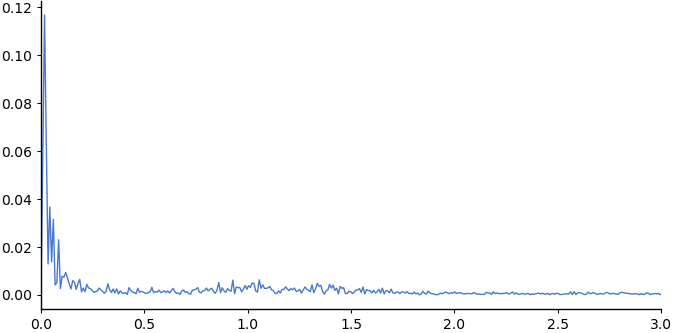

In [143]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(xf,yf_norm[:,25])
ax1.set_xlim(0, 3)

(599, 32)


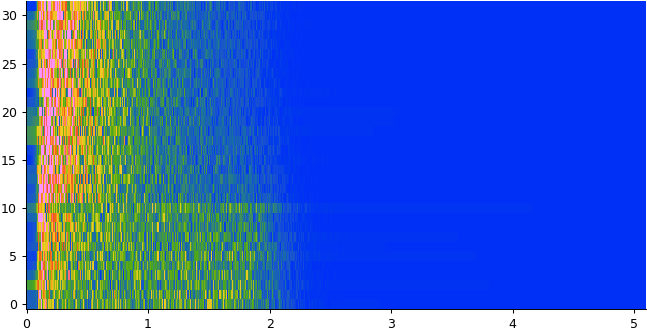

In [39]:
embryo = 9
embryo_traces = dFF_traces[embryo-1].T
fs = 10.2
# but = signal.butter(4, 2, btype="lowpass", output="sos", fs=fs)
but = signal.butter(7, (0.1, 2), btype="bandpass", output="sos", fs=fs)

embryo_traces = signal.sosfiltfilt(but, embryo_traces, axis=0)
T = 1/fs
n_samples = embryo_traces.shape[0]
yf = np.abs(fft.fft(embryo_traces-embryo_traces.mean(axis=0), axis=0)[:n_samples//2,:])
print(yf.shape)
xf = fft.fftfreq(n_samples, T)[:n_samples//2]
yf_norm = yf/np.sum(yf, axis=0)
fig1, ax1 = plt.subplots(figsize=(8,4))
vmin = np.nanpercentile(yf_norm, 1)
vmax = np.nanpercentile(yf_norm, 99)
ax1.pcolormesh(xf, np.arange(embryo_traces.shape[1]),
    yf_norm.T, cmap="cet_CET_R1", vmin=vmin, vmax=vmax)

0.02270610036379887 0.01
0.023310497938822918 0.01
0.023455715001096042 0.01
0.022888524533727413 0.01
0.022116652029032756 0.01
0.024236148516945052 0.01
0.020581624740462524 0.01
0.02310139851465029 0.01
0.020806047532085373 0.01
0.023103465533404203 0.01


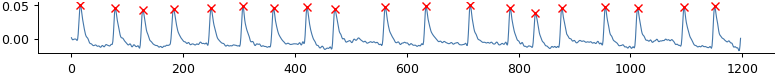

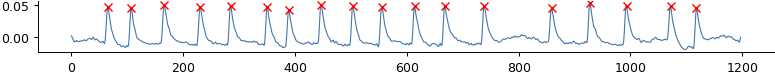

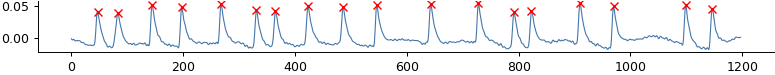

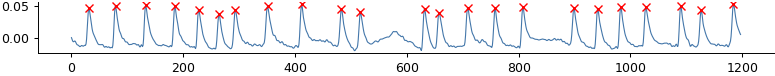

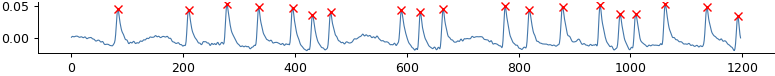

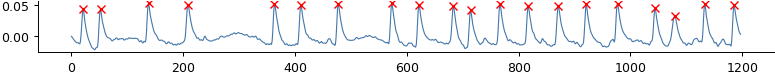

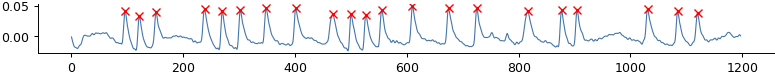

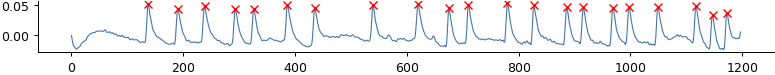

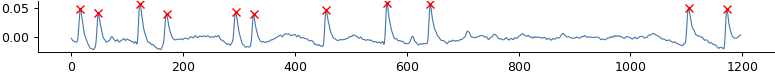

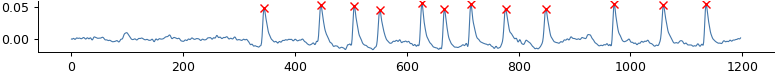

In [40]:
%matplotlib inline
curr_min_prom = 100
for tr in embryo_traces.T[-10:]:
    res = traces.analyze_peaks(tr, threshold=0.01, prominence="auto", auto_prom_scale=0.5,
        auto_thresh_scale=1, min_prom=0.015,
        wlen=50, baseline_duration=100, baseline_start=0, return_full=True)
    fig1, ax1 = plt.subplots(figsize=(8,1))
    ax1.plot(tr)
    if res:
        spikes, p, t = res
        curr_min_prom = min(curr_min_prom, p)

        print(p, t)
        if spikes is not None and len(spikes["peak_idx"]) > 0:
            ax1.plot(spikes["peak_idx"], tr[spikes["peak_idx"]], "rx")
    plt.tight_layout()
    

/tmp/ipykernel_506/1139328846.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(figsize=(8,1))


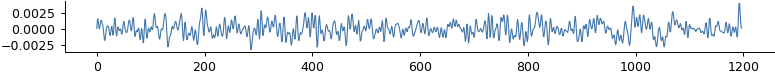

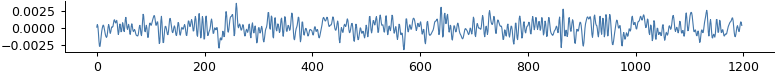

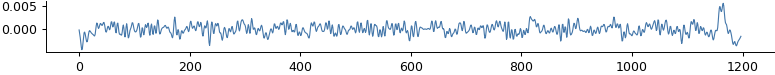

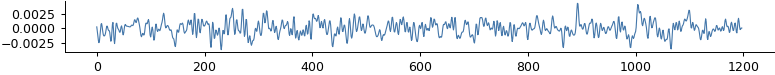

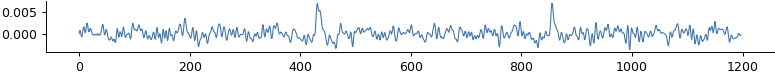

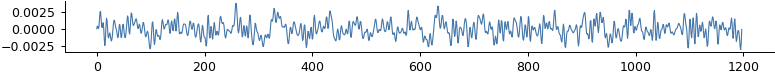

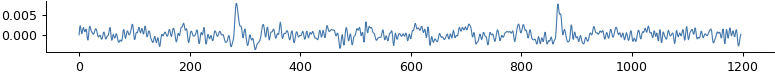

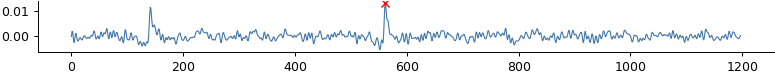

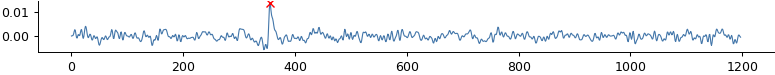

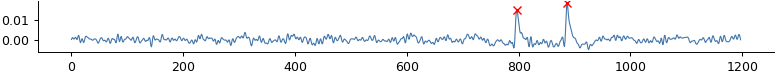

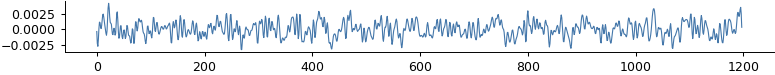

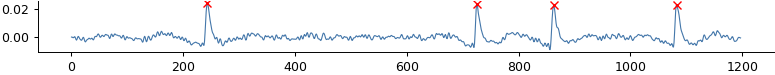

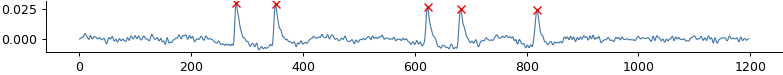

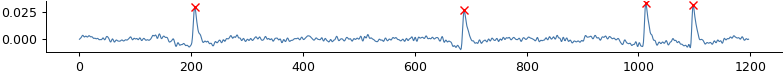

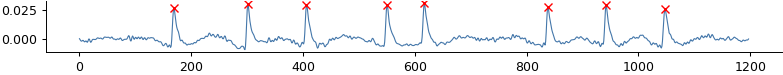

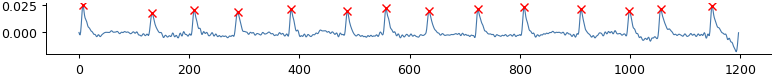

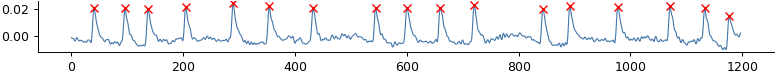

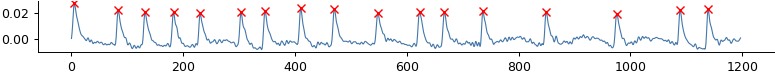

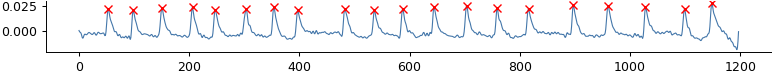

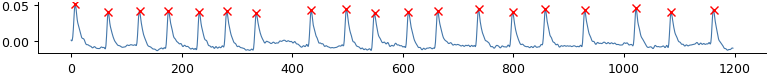

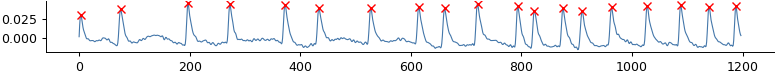

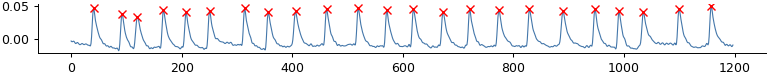

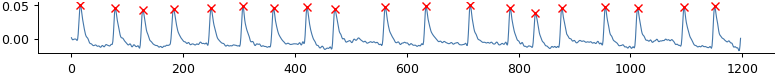

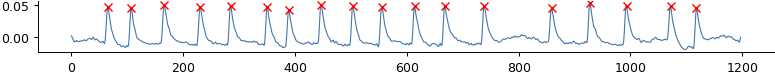

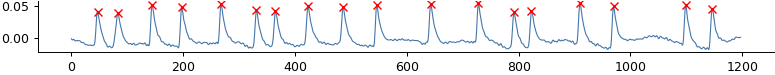

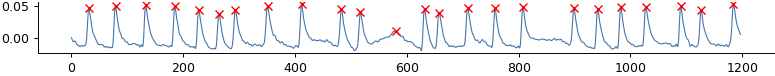

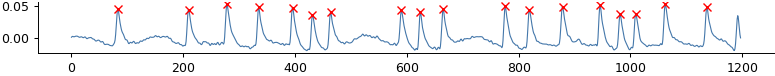

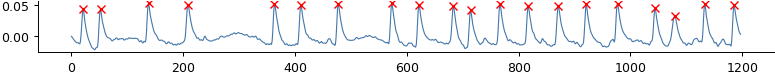

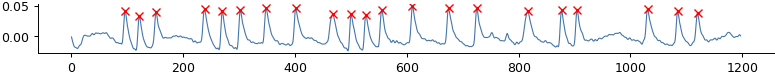

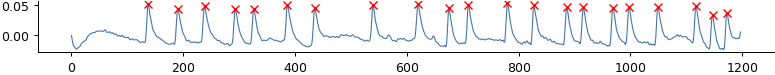

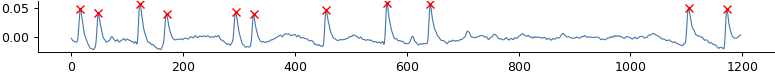

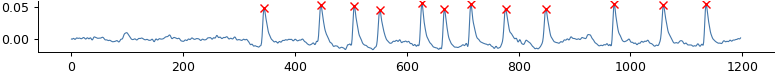

In [54]:
plt.close("all")
all_pks = []
for tr in embryo_traces.T:
    res = traces.analyze_peaks(tr, threshold=0.005, prominence=curr_min_prom*0.75, auto_prom_scale=0.5,
        auto_thresh_scale=1, min_prom=0.003,
        wlen=100, baseline_duration=100, baseline_start=0, return_full=True, max_width=35, min_width=5)
    fig1, ax1 = plt.subplots(figsize=(8,1))
    ax1.plot(tr)
    if res:
        spikes, p, t = res
        if spikes is not None and len(spikes["peak_idx"]) > 0:
            ax1.plot(spikes["peak_idx"], tr[spikes["peak_idx"]], "rx")
            all_pks.append(spikes)
    plt.tight_layout()
all_pks = pd.concat(all_pks, axis=0)

Batch analyze all embryos

In [ ]:
for mo in ["atp", "slc"]:
    expt_info.loc[mo, "offset"] = expt_info.loc[mo, "offset"] - expt_info.loc[mo, "offset"].min()
expt_info["hpf"] = expt_info["offset"]/3600 + 20.25

In [55]:
def process_condition_data(mo, fs=10.2, band=(0,2)):
    """ Turn traces into peak data
    """
    mo_dfs = []
    mo_folder = Path(
        rootdir, subfolder, "analysis", "individual_fish_recordings", mo
    )
    with open(mo_folder / "all_trace_data.pickle", "rb") as f:
        data = pickle.load(f)
    
    # Get DFF and lowpass filter
    dat_traces = np.stack(data["traces"])
    dFF_traces = traces.intensity_to_dff(dat_traces, percentile_threshold=10, axis=-1)
    if band[0] == 0:
        but = signal.butter(7, band[1], btype="lowpass", output = "sos", fs=fs)
    else:
        but = signal.butter(7, band, btype="bandpass", output = "sos", fs=fs)
    dFF_traces = signal.sosfiltfilt(but, dFF_traces, axis=-1)

    # Fourier transform
    T = 1/fs
    n_samples = dFF_traces.shape[-1]
    ampl_spectrum = np.abs(fft.fft(dFF_traces-dFF_traces.mean(axis=-1, keepdims=True), axis=-1)[...,:n_samples//2])
    ampl_spectrum_norm = ampl_spectrum/np.sum(ampl_spectrum, axis=-1, keepdims=True)
    xf = fft.fftfreq(n_samples, T)[:n_samples//2]

    for idx, embryo_traces in enumerate(dFF_traces):
        # Determine prominence for peak detection from timepoints with known peaks
        if mo == "slc" and ~data["is_control"][idx]:
            baseline_prom_indices = np.arange(5)
        else:
            baseline_prom_indices = np.arange(-5,0)
        curr_min_prom = 100
        for tr in embryo_traces[baseline_prom_indices]:
            res = traces.analyze_peaks(tr, threshold=0.01, prominence="auto", auto_prom_scale=0.5,
                auto_thresh_scale=1, min_prom=0.012,
                wlen=100, baseline_duration=100, baseline_start=0, return_full=True)
            if res:
                spikes, p, t = res
                curr_min_prom = min(curr_min_prom, p)
        
        # Detect peaks and plot
        fig1, axes = visualize.tile_plots_conditions(embryo_traces, (8,1.5),
                                                    n_rows=len(embryo_traces), disp_titles=False,
                                                    show_axis=False)
        for tr_idx, tr in enumerate(embryo_traces):
            axes[tr_idx].plot(tr)
            res = traces.analyze_peaks(tr, threshold=0.005, prominence=curr_min_prom*0.75, wlen=100, min_width=5, max_width=30)
            if res is not None:
                res["embryo"] = idx+1
                res["is_control"] = data["is_control"][idx]
                res["hpf"] = expt_info.loc[mo, "hpf"][tr_idx] + res["peak_idx"]/fs/3600
                res["trace"] = tr_idx
                # print(res)
                mo_dfs.append(res)
                axes[tr_idx].plot(res["peak_idx"], tr[res["peak_idx"]], "rx")
        plt.savefig(os.path.join(mo_folder, f"embryo_{idx+1}_peaks.svg"))
        plt.close(fig1)
    mo_df = pd.concat(mo_dfs, axis=0)
    mo_df["mo"] = mo
    return mo_df, xf, ampl_spectrum_norm

In [56]:
%matplotlib agg
plt.close("all")
combined_data = []
spectrum_data = []
xfs = []
bands = [(0.1, 2), (0,2)]
for idx, mo in enumerate(["atp", "slc"]):
    peak_df, xf, ampl_spectrum_norm = process_condition_data(mo, fs=10.2, band=bands[idx])
    combined_data.append(peak_df)
    spectrum_data.append(ampl_spectrum_norm)
    xfs.append(xfs)
combined_data = pd.concat(combined_data, axis=0).reset_index(drop=True)
combined_data.replace({"is_control": {True: "Control", False: "KD"},
                       "mo": {"atp": "atp1a1", "slc": "ncx1h"}
                       }, inplace=True)

/mnt/e/Documents/Cohen Lab/Code/SpikeCounter/spikecounter/analysis/traces.py:523: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(masked_intensity, axis=axis)[..., None]
/home/billj/miniconda3/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


In [39]:
with open(Path(rootdir, subfolder, "analysis", "individual_fish_recordings", "spectrum_data.pickle"), "wb") as f:
    pickle.dump({"yf": spectrum_data, "xf" :xf, "mo": ["atp", "slc"]}, f)
combined_data.to_csv(Path(rootdir, subfolder, "analysis", "individual_fish_recordings", "combined_data.csv"), index=False)

Representative traces for ncx and atp1a1 MOs

In [89]:
mo = "atp"
mo_folder = Path(
    rootdir, subfolder, "analysis", "individual_fish_recordings", mo
)
with open(mo_folder / "all_trace_data.pickle", "rb") as f:
    data = pickle.load(f)
# Get DFF and lowpass filter
dat_traces = np.stack(data["traces"])
dFF_traces = traces.intensity_to_dff(dat_traces, percentile_threshold=10, axis=-1)

$3\%$
$\Delta F/F$


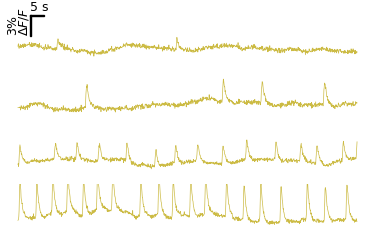

In [113]:
mo = "atp"
mo_folder = Path(
    rootdir, subfolder, "analysis", "individual_fish_recordings", mo
)
with open(mo_folder / "all_trace_data.pickle", "rb") as f:
    data = pickle.load(f)
# Get DFF and lowpass filter
dat_traces = np.stack(data["traces"])
dFF_traces = traces.intensity_to_dff(dat_traces, percentile_threshold=10, axis=-1)

rep_embryo = 8
rep_traces = [7, 11, 15, 19]
nrows = len(rep_traces)
ncols = 1
fig1, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 0.6*nrows))
axes = axes.ravel()
fs = 10.2
dt = 1/fs

for j, i in enumerate(rep_traces):
    axes[j].plot(np.arange(dFF_traces.shape[2])*dt, dFF_traces[rep_embryo, i], linewidth=0.5, color="C3")
    ylim = axes[j].get_ylim()
    axes[j].set_ylim(ylim[0], ylim[0]+ 0.06)
    axes[j].set_axis_off()
plt.tight_layout()

xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+10,
    "corner_y": ylim[1]*0.95,
    "ampl_scale": (ylim[1]-ylim[0])*0.5,
    "time_scale": 5,
    "fontsize": 9,
    "thickness": (ylim[1]-ylim[0])*0.02,
    "xlabel_offset_y": (ylim[1]-ylim[0])*0.12,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -8,
    "ylabel_offset_y": 0.007
    }
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
plt.savefig(output_datadir/"rep_traces_atp1a1.svg", dpi=300, bbox_inches="tight")

$10\%$
$\Delta F/F$


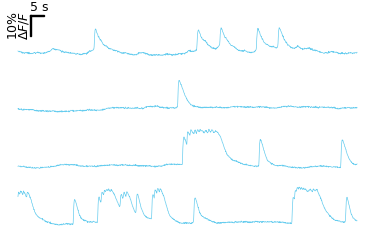

In [115]:
mo = "slc"
mo_folder = Path(
    rootdir, subfolder, "analysis", "individual_fish_recordings", mo
)
with open(mo_folder / "all_trace_data.pickle", "rb") as f:
    data = pickle.load(f)
# Get DFF and lowpass filter
dat_traces = np.stack(data["traces"])
dFF_traces = traces.intensity_to_dff(dat_traces, percentile_threshold=10, axis=-1)

rep_embryo = 6
rep_traces = [3, 7, 11, 15]
nrows = len(rep_traces)
ncols = 1
fig1, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 0.6*nrows))
axes = axes.ravel()
fs = 10.2
dt = 1/fs

for j, i in enumerate(rep_traces):
    axes[j].plot(np.arange(dFF_traces.shape[2])*dt, dFF_traces[rep_embryo, i], linewidth=0.5, color="C4")
    ylim = axes[j].get_ylim()
    axes[j].set_ylim(ylim[0], ylim[0]+ 0.2)
    axes[j].set_axis_off()
plt.tight_layout()

xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+10,
    "corner_y": ylim[1]*0.95,
    "ampl_scale": (ylim[1]-ylim[0])*0.5,
    "time_scale": 5,
    "fontsize": 9,
    "thickness": (ylim[1]-ylim[0])*0.02,
    "xlabel_offset_y": (ylim[1]-ylim[0])*0.12,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -8,
    "ylabel_offset_y": 0.007
    }
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
plt.savefig(output_datadir/"rep_traces_ncx.svg", dpi=300, bbox_inches="tight")

Plot summary statistics

In [5]:
combined_data = pd.read_csv(rootdir/subfolder/"analysis"/"individual_fish_recordings"/"combined_data.csv")

In [6]:
first_spikes = combined_data.groupby(["mo", "is_control", "embryo"]).first().reset_index()

In [7]:
first_spikes

,mo,is_control,embryo,peak_idx,prominence,fwhm,isi,hpf,trace
0,atp1a1,Control,5,68,0.038231,8.381024,35.0,20.251852,0
1,atp1a1,Control,10,846,0.071702,9.550025,34.0,20.273039,0
2,atp1a1,Control,15,111,0.018191,8.226018,97.0,20.341634,1
3,atp1a1,KD,1,727,0.009596,5.406805,541.0,20.269798,0
4,atp1a1,KD,2,125,0.010602,27.616944,387.0,21.211182,10
5,atp1a1,KD,3,421,0.009211,23.039292,206.0,21.323132,11
6,atp1a1,KD,4,492,0.045469,11.278201,200.0,20.352010,1
7,atp1a1,KD,6,812,0.015649,9.538760,378.0,21.036002,8
8,atp1a1,KD,7,78,0.030983,8.393967,102.0,22.388791,22
9,atp1a1,KD,8,233,0.011876,29.609883,292.0,20.830234,6


In [7]:
first_spikes["expt_cond"] = first_spikes["mo"].map({"atp1a1": 1, "ncx1h":2}) * (first_spikes["is_control"]=="KD")
first_spikes["expt_cond"] = first_spikes["expt_cond"].map({0: "Control", 1: "atp1a1", 2: "ncx1h"})

In [8]:
grouped_data = first_spikes.set_index(["mo", "is_control"])
for idx in grouped_data.index.unique():
    print(idx, stats.shapiro(grouped_data.loc[idx]["hpf"]))

('atp1a1', 'Control') ShapiroResult(statistic=0.9149653315544128, pvalue=0.43485915660858154)
('atp1a1', 'KD') ShapiroResult(statistic=0.8814781308174133, pvalue=0.09155476093292236)
('ncx1h', 'Control') ShapiroResult(statistic=0.9973999261856079, pvalue=0.9025714993476868)
('ncx1h', 'KD') ShapiroResult(statistic=0.8056538701057434, pvalue=0.01698239892721176)


                   embryo  peak_idx  prominence  fwhm  isi  hpf  trace
mo     is_control                                                     
atp1a1 Control          3         3           3     3    3    3      3
       KD              12        12          12    12   12   12     12
ncx1h  Control          3         3           3     3    3    3      3
       KD              10        10          10    10   10   10     10
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ncx1h_Control vs. ncx1h_KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.399e-02 U_stat=1.000e+00


/home/billj/miniconda3/envs/bjia2/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/billj/miniconda3/envs/bjia2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/billj/miniconda3/envs/bjia2/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/billj/miniconda3/envs/bjia2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


atp1a1_Control vs. atp1a1_KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.363e-01 U_stat=7.000e+00


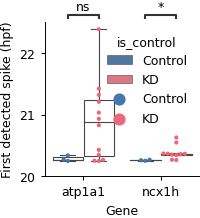

In [28]:
%matplotlib inline
print(first_spikes.groupby(["mo", "is_control"]).count())
x = "mo"
y = "hpf"
hue = "is_control"
order = ["Control", "KD"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(2,2))
    sns.boxplot(data=first_spikes, x=x, y=y, hue=hue, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, hue_order=order)
    sns.swarmplot(data=first_spikes, x=x, y=y, hue=hue, dodge=True, ax=ax1, s=3, hue_order=order)
    ax1.set_xlabel("Gene")
    ax1.set_ylabel("First detected spike (hpf)")
    ax1.set_ylim(20, 22.5)
    ax1.set_yticks([20,21,22])
    pairs = [[("atp1a1", "Control"), ("atp1a1", "KD")], [("ncx1h", "Control"), ("ncx1h", "KD")]]
    # ax1.legend(["Control", "MO"], title="", handletextpad=-0.5)
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=first_spikes, x=x,y=y, hue=hue, hue_order=order)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
    annot.apply_and_annotate()

In [9]:
expt_names_mo = {"tnnt2a": "20211022_widefield_tnnt2aMO_control", "hcn4": "20210929_widefield_hcn4mo"}

In [10]:
uninjected_start_time = pd.read_csv(output_datadir.parents[1]/"Figure1/all_uninjected_widefield_start_hpfs.csv")
del uninjected_start_time["Unnamed: 0"]
tnnt2a_start_time = pd.read_csv(output_datadir.parents[1]/"Figure1"/expt_names_mo["tnnt2a"]/"start_hpfs.csv")
del tnnt2a_start_time["Unnamed: 0"]
hcn4_start_time = pd.read_csv(output_datadir.parents[0]/expt_names_mo["hcn4"]/"start_hpfs.csv")

In [11]:
mo_start_time = first_spikes[first_spikes["is_control"] != "Control"][["mo", "embryo", "hpf"]]
mo_start_time["condition"] = mo_start_time["mo"].astype(str) + "_mo"
mo_start_time["experiment"] = expt_dir_name
mo_start_time["start_hpf"] = mo_start_time["hpf"]
del mo_start_time["hpf"]
del mo_start_time["mo"]

In [12]:
all_start_times = pd.concat([uninjected_start_time, tnnt2a_start_time, hcn4_start_time, mo_start_time], axis=0)

In [14]:
all_start_times.groupby(["condition"]).mean()["start_hpf"]

/tmp/ipykernel_660/119132659.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_start_times.groupby(["condition"]).mean()["start_hpf"]


condition
atp1a1_mo     20.892235
hcn4_mo       20.133648
ncx1h_mo      20.389064
tnnt2a_mo     20.448938
uninjected    20.276634
Name: start_hpf, dtype: float64

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a_mo: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.749e-02 U_stat=1.540e+02
uninjected vs. hcn4_mo: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.112e-01 U_stat=2.830e+02
uninjected vs. atp1a1_mo: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.233e-03 U_stat=8.800e+01
uninjected vs. ncx1h_mo: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.468e-02 U_stat=1.250e+02


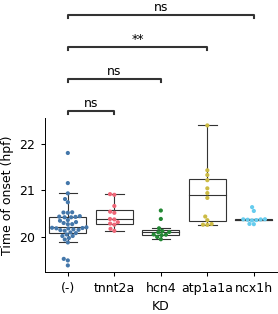

In [30]:
x = "condition"
y = "start_hpf"
order = ["uninjected", "tnnt2a_mo", "hcn4_mo", "atp1a1_mo","ncx1h_mo"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=all_start_times, x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=all_start_times, x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("Time of onset (hpf)")

    pairs = [("uninjected", "tnnt2a_mo"), ("uninjected", "hcn4_mo"), ("uninjected", "atp1a1_mo"), ("uninjected", "ncx1h_mo")]
    # ax1.legend(["Control", "MO"], title="", handletextpad=-0.5)
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=all_start_times, order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    ax1.set_xticklabels(["(-)", "tnnt2a", "hcn4", "atp1a1a", "ncx1h"])
plt.savefig(output_datadir/"start_hpf_morphants.svg", dpi=300, bbox_inches="tight")

                   embryo  peak_idx  prominence  fwhm  isi  hpf  trace  \
mo     is_control                                                        
atp1a1 Control          3         3           3     3    3    3      3   
       KD              12        12          12    12   12   12     12   
ncx1h  Control          3         3           3     3    3    3      3   
       KD              10        10          10    10   10   10     10   

                   expt_cond  
mo     is_control             
atp1a1 Control             3  
       KD                 12  
ncx1h  Control             3  
       KD                 10  
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.200e-02 U_stat=1.300e+01
Control vs. ncx1h: Mann-Whitney-Wilcoxon test two-sided, P_val:4.745e-03 U_stat=5.000e+00


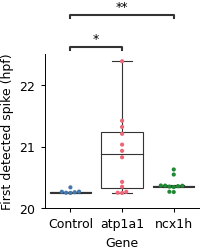

In [34]:
%matplotlib inline
print(first_spikes.groupby(["mo", "is_control"]).count())
x = "expt_cond"
y = "hpf"
order = ["Control", "atp1a1", "ncx1h"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(2,2))
    sns.boxplot(data=first_spikes, x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, hue_order=order)
    sns.swarmplot(data=first_spikes, x=x, y=y, dodge=True, ax=ax1, s=3)
    ax1.set_xlabel("Gene")
    ax1.set_ylabel("First detected spike (hpf)")
    ax1.set_ylim(20, 22.5)
    ax1.set_yticks([20,21,22])
    pairs = [("Control", "atp1a1"), ("Control", "ncx1h")]
    # ax1.legend(["Control", "MO"], title="", handletextpad=-0.5)
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=first_spikes, x=x,y=y,)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
    annot.apply_and_annotate()



In [14]:
per_recording_measurements = combined_data.groupby(["mo", "is_control", "embryo", "trace"])
freq = per_recording_measurements.count()["peak_idx"].reset_index().set_index(["mo", "is_control", "embryo"])
freq["freq"] = freq["peak_idx"]/120
isi_cv = per_recording_measurements["isi"].std()/per_recording_measurements["isi"].mean()
isi_cv = isi_cv.reset_index().set_index(["mo", "is_control", "embryo"]).rename(columns={"isi": "isi_cv"})

In [15]:
expt_info2 = expt_info.reset_index().replace({"morpholino": {"atp": "atp1a1", "slc": "ncx1h"}
                   }).set_index("morpholino")

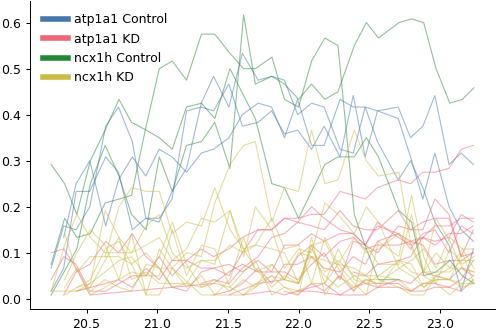

In [85]:
fig1, ax1 = plt.subplots(figsize=(6,4))
for embryo_idx in freq.index.unique():
    if embryo_idx[0] == "atp1a1" and embryo_idx[1] == "Control":
        color = "C0"
    elif embryo_idx[0] == "atp1a1" and embryo_idx[1] == "KD":
        color = "C1"
    elif embryo_idx[0] == "ncx1h" and embryo_idx[1] == "Control":
        color = "C2"
    else:
        color= "C3"
    tpoints = expt_info2.loc[embryo_idx[0], "hpf"].values[freq.loc[embryo_idx, "trace"].values]
    ax1.plot(tpoints, freq.loc[embryo_idx, "freq"], color=color, alpha=0.5)
custom_legend_entries = [lines.Line2D([0], [0], color="C0", lw=4), lines.Line2D([0], [0], color="C1", lw=4), lines.Line2D([0], [0], color="C2", lw=4), lines.Line2D([0], [0], color="C3", lw=4)]
ax1.legend(custom_legend_entries, ["atp1a1 Control", "atp1a1 KD", "ncx1h Control", "ncx1h KD"], title="", handletextpad=0.5)

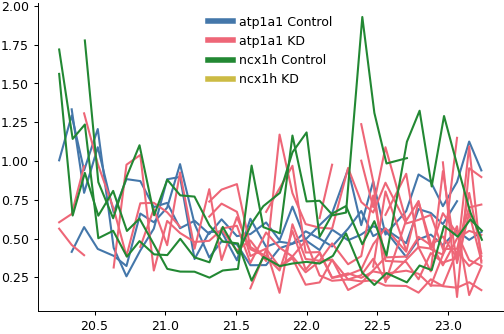

In [92]:
fig1, ax1 = plt.subplots(figsize=(6,4))
for embryo_idx in isi_cv.index.unique():
    if embryo_idx[0] == "atp1a1" and embryo_idx[1] == "Control":
        color = "C0"
    elif embryo_idx[0] == "atp1a1" and embryo_idx[1] == "KD":
        color = "C1"
    elif embryo_idx[0] == "ncx1h" and embryo_idx[1] == "Control":
        color = "C2"
    else:
        color= "C3"
    if embryo_idx[0] == "ncx1h" and embryo_idx[1] == "KD":
        continue
    tpoints = expt_info2.loc[embryo_idx[0], "hpf"].values[freq.loc[embryo_idx, "trace"].values]
    ax1.plot(tpoints, isi_cv.loc[embryo_idx, "isi_cv"], color=color, linewidth=1.5)
custom_legend_entries = [lines.Line2D([0], [0], color="C0", lw=4), lines.Line2D([0], [0], color="C1", lw=4), lines.Line2D([0], [0], color="C2", lw=4), lines.Line2D([0], [0], color="C3", lw=4)]
ax1.legend(custom_legend_entries, ["atp1a1 Control", "atp1a1 KD", "ncx1h Control", "ncx1h KD"], title="", handletextpad=0.5)

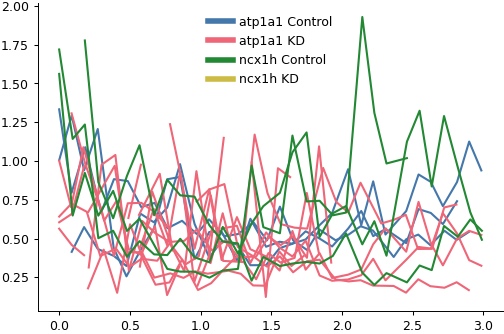

In [96]:
fig1, ax1 = plt.subplots(figsize=(6,4))
for embryo_idx in isi_cv.index.unique():
    if embryo_idx[0] == "atp1a1" and embryo_idx[1] == "Control":
        color = "C0"
    elif embryo_idx[0] == "atp1a1" and embryo_idx[1] == "KD":
        color = "C1"
    elif embryo_idx[0] == "ncx1h" and embryo_idx[1] == "Control":
        color = "C2"
    else:
        color= "C3"
    if embryo_idx[0] == "ncx1h" and embryo_idx[1] == "KD":
        continue
    tpoints = expt_info2.loc[embryo_idx[0], "hpf"].values[freq.loc[embryo_idx, "trace"].values]
    tpoints -= tpoints[0]
    ax1.plot(tpoints, isi_cv.loc[embryo_idx, "isi_cv"], color=color, linewidth=1.5)
custom_legend_entries = [lines.Line2D([0], [0], color="C0", lw=4), lines.Line2D([0], [0], color="C1", lw=4), lines.Line2D([0], [0], color="C2", lw=4), lines.Line2D([0], [0], color="C3", lw=4)]
ax1.legend(custom_legend_entries, ["atp1a1 Control", "atp1a1 KD", "ncx1h Control", "ncx1h KD"], title="", handletextpad=0.5)

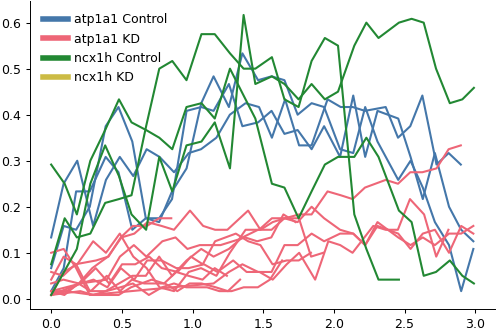

In [98]:
fig1, ax1 = plt.subplots(figsize=(6,4))
for embryo_idx in freq.index.unique():
    if embryo_idx[0] == "atp1a1" and embryo_idx[1] == "Control":
        color = "C0"
    elif embryo_idx[0] == "atp1a1" and embryo_idx[1] == "KD":
        color = "C1"
    elif embryo_idx[0] == "ncx1h" and embryo_idx[1] == "Control":
        color = "C2"
    else:
        color= "C3"
    if embryo_idx[0] == "ncx1h" and embryo_idx[1] == "KD":
        continue
    tpoints = expt_info2.loc[embryo_idx[0], "hpf"].values[freq.loc[embryo_idx, "trace"].values]
    tpoints -= tpoints[0]
    ax1.plot(tpoints, freq.loc[embryo_idx, "freq"], color=color, linewidth=1.5)
custom_legend_entries = [lines.Line2D([0], [0], color="C0", lw=4), lines.Line2D([0], [0], color="C1", lw=4), lines.Line2D([0], [0], color="C2", lw=4), lines.Line2D([0], [0], color="C3", lw=4)]
ax1.legend(custom_legend_entries, ["atp1a1 Control", "atp1a1 KD", "ncx1h Control", "ncx1h KD"], title="", handletextpad=0.5)

Compare frequency vs CV among all the perturbations

In [16]:
all_morpholino_moments = {"uninjected": [], "tnnt2a": [], "hcn4": [], "atp1a1": []}

In [17]:
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [output_datadir.parents[1]/"Figure2"/d for d in expts]
for datadir in datadirs:
    all_morpholino_moments["uninjected"].append(scio.loadmat((datadir/"all_moments.mat").as_posix()))

In [18]:
all_morpholino_moments["tnnt2a"].append(scio.loadmat((output_datadir.parents[1]/"Figure1"/expt_names_mo["tnnt2a"]/"all_moments.mat").as_posix()))
all_morpholino_moments["hcn4"].append(scio.loadmat((output_datadir.parents[1]/"Figure3"/expt_names_mo["hcn4"]/"all_moments.mat").as_posix()))

In [19]:
per_recording_measurements = combined_data.groupby(["is_control", "mo", "embryo", "trace"])
freq = per_recording_measurements.count()["peak_idx"].reset_index().set_index(["is_control", "mo", "embryo"])
freq["freq"] = freq["peak_idx"]/120
isi_cv = per_recording_measurements["isi"].std()/per_recording_measurements["isi"].mean()
isi_cv = isi_cv.reset_index().set_index(["is_control", "mo", "embryo"]).rename(columns={"isi": "isi_cv"})

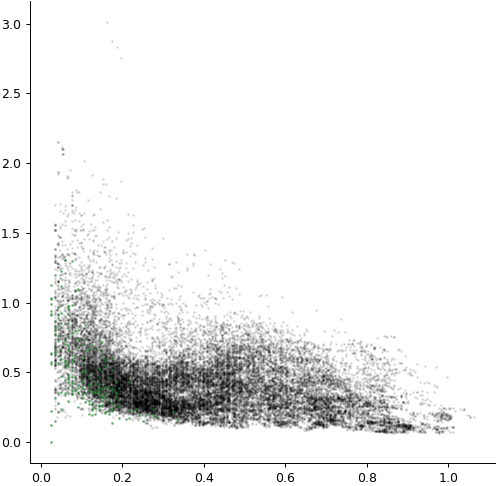

In [119]:
fig1, ax1 = plt.subplots(figsize=(6,6))
for idx, moments in enumerate(expt_moments):
    freqs = moments["all_freqs"]
    covs = moments["covs"]
    ax1.scatter(freqs[freqs>0], covs[freqs>0], s=1, alpha=0.1, color="k")
# tnnt_moments = scio.loadmat((output_datadir.parents[1]/"Figure1"/expt_names_mo["tnnt2a"]/"all_moments.mat").as_posix())
# freqs = tnnt_moments["all_freqs"]
# covs = tnnt_moments["covs"]
# ax1.scatter(freqs[freqs>0], covs[freqs>0], s=1, alpha=0.5, color="C0", label="tnnt2a")

# hcn4_moments = scio.loadmat((output_datadir.parents[1]/"Figure3"/expt_names_mo["hcn4"]/"all_moments.mat").as_posix())
# freqs = hcn4_moments["all_freqs"]
# covs = hcn4_moments["covs"]
# ax1.scatter(freqs[freqs>0], covs[freqs>0], s=1, alpha=0.5, color="C1", label="hcn4")

ax1.scatter(freq.loc[("KD", "atp1a1"), "freq"], isi_cv.loc[("KD", "atp1a1"), "isi_cv"], s=1, alpha=0.5, color="C2", label="atp1a1")

In [20]:
test_freqs = [0.05, 0.1, 0.2, 0.4, 0.6]
window = 0.01
freq_window_dfs = []
for f in test_freqs:
    dfs_list = []
    freq_window = (freq["freq"] > f-window) & (freq["freq"] < f+window)
    try:
        mean_cv = isi_cv[freq_window].loc[("KD", "atp1a1"), "isi_cv"].groupby("embryo").mean()
        dfs_list.append(pd.DataFrame({"embryo": mean_cv.index, "isi_cv": mean_cv.values, "condition": "atp1a1", "mean_freq": f}))
    except:
        pass
    for key, moments_list in all_morpholino_moments.items():
        if key == "atp1a1":
            continue
        for moments in moments_list:
            trace_freqs = moments["all_freqs"]
            trace_cvs = moments["covs"]
            trace_freqs = trace_freqs[:, ::10]
            trace_cvs = trace_cvs[:, ::10]
            mask = (trace_freqs > f-window) & (trace_freqs < f+window) & np.isfinite(trace_cvs)
            mean_cv = np.ma.masked_array(trace_cvs, ~mask).mean(axis=1)
            dfs_list.append(pd.DataFrame({"embryo": np.arange(len(mean_cv)), "isi_cv": mean_cv, "condition": key, "mean_freq": f}))
    curr_window_df = pd.concat(dfs_list)
    freq_window_dfs.append(curr_window_df)
    curr_window_df.to_csv(output_datadir.parent/f"freq_window_{f}.csv", index=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.854e-01 U_stat=8.900e+01
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.180e-01 U_stat=5.100e+01
uninjected vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.337e-01 U_stat=1.860e+02


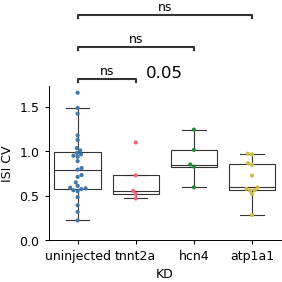

In [168]:
x = "condition"
y = "isi_cv"
idx = 0
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=freq_window_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=freq_window_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("ISI CV")
    ax1.set_ylim(0, None)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4"), ("uninjected", "atp1a1")]
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=freq_window_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    ax1.set_title(test_freqs[idx])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.583e-02 U_stat=4.200e+01
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.654e-01 U_stat=6.600e+01
uninjected vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.764e-01 U_stat=1.730e+02


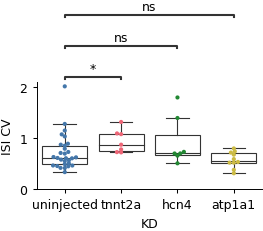

In [32]:
x = "condition"
y = "isi_cv"
idx = 1
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,1.75))
    sns.boxplot(data=freq_window_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=freq_window_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("ISI CV")
    ax1.set_ylim(0, None)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4"), ("uninjected", "atp1a1")]
    plt.tight_layout()
    annot = Annotator(ax1, pairs, data=freq_window_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    plt.savefig(output_datadir.parent/f"freq_window_{test_freqs[idx]}_ISI_CV.svg", dpi=300, bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.578e-03 U_stat=7.300e+01
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.463e-01 U_stat=1.760e+02


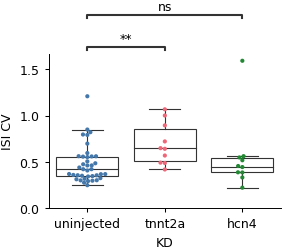

In [170]:
x = "condition"
y = "isi_cv"
idx = 2
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=freq_window_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=freq_window_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("ISI CV")
    ax1.set_ylim(0, None)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4")]
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=freq_window_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.373e-02 (ns) U_stat=7.300e+01
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.556e-02 U_stat=7.600e+01


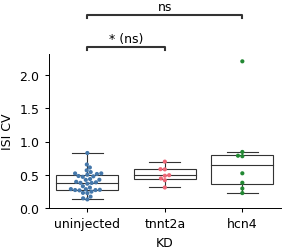

In [171]:
x = "condition"
y = "isi_cv"
idx = 3
order = ["uninjected", "tnnt2a", "hcn4"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=freq_window_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=freq_window_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("ISI CV")
    ax1.set_ylim(0, None)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4")]
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=freq_window_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.350e-01 U_stat=5.600e+01
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.519e-01 U_stat=4.300e+01


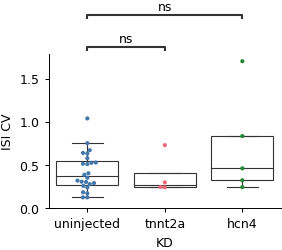

In [172]:
x = "condition"
y = "isi_cv"
idx = 4
order = ["uninjected", "tnnt2a", "hcn4"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=freq_window_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=freq_window_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("ISI CV")
    ax1.set_ylim(0, None)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4")]
    # plt.tight_layout()
    annot = Annotator(ax1, pairs, data=freq_window_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()

Compare frequency at 1h after onset.

In [23]:
kd_data = combined_data.set_index(["is_control", "mo"]).loc[("KD", "atp1a1")]
trace_times = kd_data.groupby(["embryo", "trace"]).first()
freqs = kd_data.groupby(["embryo", "trace"]).count()["peak_idx"]/120


/tmp/ipykernel_1409/3915451298.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  kd_data = combined_data.set_index(["is_control", "mo"]).loc[("KD", "atp1a1")]


In [24]:
time_cutoff_dfs = []
cutoffs = [0.5, 0.75, 1]
for cutoff in cutoffs:
    dfs_list = []

    cutoff_freqs = []
    cutoff_hpfs = []
    for embryo in trace_times.index.unique("embryo"):
        hpf_offsets = trace_times.loc[embryo, "hpf"] - trace_times.loc[embryo, "hpf"].min()
        try:
            cutoff_idx = np.argwhere(hpf_offsets.values > cutoff).ravel()[0]
        except:
            continue
        cutoff_freqs.append(freqs.loc[embryo].iloc[cutoff_idx])
        cutoff_hpfs.append(trace_times.loc[embryo, "hpf"].iloc[cutoff_idx])
    cutoff_freq_df = pd.DataFrame({"freq": cutoff_freqs,
                                "cond": "atp1a1",
                                "embryo": np.arange(len(cutoff_freqs)),
                                "hpf": cutoff_hpfs})
    dfs_list.append(cutoff_freq_df)

    for key, moments_list in all_morpholino_moments.items():
        if key == "atp1a1":
            continue
        for moments in moments_list:
            aligned_frequencies, global_time_freq = utils.align_traces([moments["all_freqs"]], [moments["idx_offsets"].ravel()])
            dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
            global_time_freq = global_time_freq*dt
            cutoff_idx = np.argwhere(global_time_freq > cutoff).ravel()[0]
            cutoff_freqs = aligned_frequencies[:,cutoff_idx]
            dfs_list.append(pd.DataFrame({"freq": cutoff_freqs,
                                            "cond": key,
                                            "embryo": np.arange(aligned_frequencies.shape[0]),
            "hpf": moments["hpf"].ravel()[moments["idx_offsets"].ravel()+cutoff_idx-moments["idx_offsets"].max()]}))
    time_cutoff_df = pd.concat(dfs_list)
    time_cutoff_df.to_csv(output_datadir.parent/f"freq_{cutoff}h.csv")
    time_cutoff_dfs.append(time_cutoff_df)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.489e-01 U_stat=1.685e+02
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.277e-01 U_stat=1.625e+02
uninjected vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.108e-05 U_stat=4.260e+02


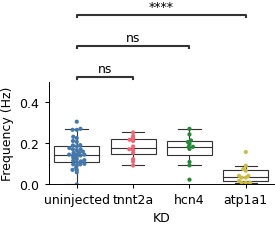

In [28]:
%matplotlib inline
x = "cond"
y = "freq"
idx = 0
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,1.75))
    sns.boxplot(data=time_cutoff_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=time_cutoff_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_ylim(0, 0.5)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4"), ("uninjected", "atp1a1")]
    plt.tight_layout()
    annot = Annotator(ax1, pairs, data=time_cutoff_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    # ax1.set_title(f"{cutoffs[idx]}h")
    plt.savefig(output_datadir.parent/f"MOs_freq_{cutoffs[idx]}h.svg", bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.026e-01 U_stat=1.600e+02
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.394e-01 U_stat=2.350e+02
uninjected vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.520e-06 U_stat=4.510e+02


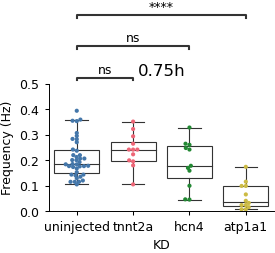

In [86]:
%matplotlib inline
x = "cond"
y = "freq"
idx = 1
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,2))
    sns.boxplot(data=time_cutoff_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=time_cutoff_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_ylim(0, 0.5)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4"), ("uninjected", "atp1a1")]
    plt.tight_layout()
    annot = Annotator(ax1, pairs, data=time_cutoff_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    ax1.set_title(f"{cutoffs[idx]}h")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninjected vs. tnnt2a: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.577e-02 U_stat=1.585e+02
uninjected vs. hcn4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.559e-01 U_stat=2.635e+02
uninjected vs. atp1a1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.710e-07 U_stat=4.260e+02


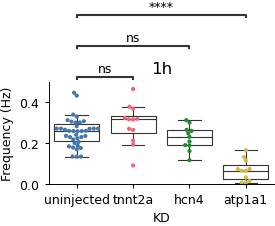

In [27]:
%matplotlib inline
x = "cond"
y = "freq"
idx = 2
order = ["uninjected", "tnnt2a", "hcn4", "atp1a1"]
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(3,1.75))
    sns.boxplot(data=time_cutoff_dfs[idx], x=x, y=y, ax=ax1, showfliers=False, boxprops={
        "facecolor": "w",
    }, order=order)
    sns.swarmplot(data=time_cutoff_dfs[idx], x=x, y=y, dodge=True, ax=ax1, s=3, order=order)
    ax1.set_xlabel("KD")
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_ylim(0, 0.5)
    pairs = [("uninjected", "tnnt2a"), ("uninjected", "hcn4"), ("uninjected", "atp1a1")]
    plt.tight_layout()
    annot = Annotator(ax1, pairs, data=time_cutoff_dfs[idx], order=order, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside", comparisons_correction="fdr_bh")
    annot.apply_and_annotate()
    ax1.set_title(f"{cutoffs[idx]}h")
    plt.savefig(output_datadir.parent/f"MOs_freq_{cutoffs[idx]}h.svg", bbox_inches="tight")